## 1. Credit card applications
<p>Commercial banks receive <em>a lot</em> of applications for credit cards. Many of them get rejected for many reasons, like high loan balances, low income levels, or too many inquiries on an individual's credit report, for example. Manually analyzing these applications is mundane, error-prone, and time-consuming (and time is money!).</p>

<p>I am automateing this task with the power of machine learning and pretty much every commercial bank does so nowadays. In this notebook, I will build an automatic credit card approval predictor using machine learning techniques, just like the real banks do.</p>
<p><img src="credit_card.jpg" alt="Credit card being held in hand"></p>
<p>I am using the <a href="http://archive.ics.uci.edu/ml/datasets/credit+approval">Credit Card Approval dataset</a> from the UCI Machine Learning Repository. The structure of this notebook is as follows:</p>

<p>The structure of this notebook is as follows:</p>
<ul>
<li>First, scrap, load and view the dataset.</li>
<li>Preprocess the dataset to ensure the machine learning model we choose can make good predictions.</li>
<li>Do some exploratory data analysis to build our intuitions.</li>
<li>Finally, build a machine learning model that can predict if an individual's application for a credit card will be accepted.</li>
</ul>

In [114]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from urllib.request import urlretrieve


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

In [115]:
urlretrieve('http://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data',
           'cc_approvals.data')

cc_apps = pd.read_csv("cc_approvals.data", header=None)
cc_apps.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


The features of this dataset have been anonymized to protect the privacy, but this blog gives us a pretty good overview of the probable features. The probable features in a typical credit card application are <code>Gender</code>, <code>Age</code>, <code>Debt</code>, <code>Married</code>, <code>BankCustomer</code>, <code>EducationLevel</code>, <code>Ethnicity</code>, <code>YearsEmployed</code>, <code>PriorDefault</code>, <code>Employed</code>, <code>CreditScore</code>, <code>DriversLicense</code>, <code>Citizen</code>, <code>ZipCode</code>, <code>Income</code> and finally the <code>ApprovalStatus</code>. As starting point, I will map these features with respect to the columns in the output.

In [116]:
cols = ['Gender', 'Age', 'Debt', 'Married', 'BankCustomer',
        'EducationLevel', 'Ethnicity', 'YearsEmployed', 'PriorDefault',
        'Employed', 'CreditScore', 'DriversLicense', 'Citizen', 'ZipCode',
        'Income', 'ApprovalStatus']
cc_apps.columns = cols
cc_apps.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          690 non-null    object 
 1   Age             690 non-null    object 
 2   Debt            690 non-null    float64
 3   Married         690 non-null    object 
 4   BankCustomer    690 non-null    object 
 5   EducationLevel  690 non-null    object 
 6   Ethnicity       690 non-null    object 
 7   YearsEmployed   690 non-null    float64
 8   PriorDefault    690 non-null    object 
 9   Employed        690 non-null    object 
 10  CreditScore     690 non-null    int64  
 11  DriversLicense  690 non-null    object 
 12  Citizen         690 non-null    object 
 13  ZipCode         690 non-null    object 
 14  Income          690 non-null    int64  
 15  ApprovalStatus  690 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 86.4+ KB


In [117]:
cc_apps.tail(20)

,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,ApprovalStatus
670,b,47.17,5.835,u,g,w,v,5.500,f,f,0,f,g,00465,150,-
671,b,25.83,12.835,u,g,cc,v,0.500,f,f,0,f,g,00000,2,-
672,a,50.25,0.835,u,g,aa,v,0.500,f,f,0,t,g,00240,117,-
673,?,29.50,2.000,y,p,e,h,2.000,f,f,0,f,g,00256,17,-
674,a,37.33,2.500,u,g,i,h,0.210,f,f,0,f,g,00260,246,-
675,a,41.58,1.040,u,g,aa,v,0.665,f,f,0,f,g,00240,237,-
676,a,30.58,10.665,u,g,q,h,0.085,f,t,12,t,g,00129,3,-
677,b,19.42,7.250,u,g,m,v,0.040,f,t,1,f,g,00100,1,-
678,a,17.92,10.210,u,g,ff,ff,0.000,f,f,0,f,g,00000,50,-
679,a,20.08,1.250,u,g,c,v,0.000,f,f,0,f,g,00000,0,-


In [118]:
cc_apps.describe()

,Debt,YearsEmployed,CreditScore,Income
count,690.000000,690.000000,690.00000,690.000000
mean,4.758725,2.223406,2.40000,1017.385507
std,4.978163,3.346513,4.86294,5210.102598
min,0.000000,0.000000,0.00000,0.000000
25%,1.000000,0.165000,0.00000,0.000000
50%,2.750000,1.000000,0.00000,5.000000
75%,7.207500,2.625000,3.00000,395.500000
max,28.000000,28.500000,67.00000,100000.000000


<p>these investigations uncovered some issues that will affect the performance of our machine learning model(s) if they go unchanged:</p>
<ul>
<li>The dataset contains both numeric and non-numeric data (specifically data that are of <code>float64</code>, <code>int64</code> and <code>object</code> types). Specifically, the features 2, 7, 10 and 14 contain numeric values (of types float64, float64, int64 and int64 respectively) and all the other features contain non-numeric values.</li>
<li>The dataset also contains values from several ranges. Some features have a value range of 0 - 28, some have a range of 2 - 67, and some have a range of 1017 - 100000. Apart from these, somw useful statistical information (like <code>mean</code>, <code>max</code>, and <code>min</code>) about the features that have numerical values. </li>
<li>Finally, the dataset has missing values. The missing values in the dataset are labeled with '?', which can be seen in the .tail(20) cell output.</li>
</ul>

In [119]:
cc_apps = cc_apps.replace('?',np.nan)
cc_apps.fillna(cc_apps.mean(), inplace=True)
print(cc_apps.isnull().sum())
cc_apps.tail(20)

Gender            12
Age               12
Debt               0
Married            6
BankCustomer       6
EducationLevel     9
Ethnicity          9
YearsEmployed      0
PriorDefault       0
Employed           0
CreditScore        0
DriversLicense     0
Citizen            0
ZipCode           13
Income             0
ApprovalStatus     0
dtype: int64


,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,ApprovalStatus
670,b,47.17,5.835,u,g,w,v,5.500,f,f,0,f,g,00465,150,-
671,b,25.83,12.835,u,g,cc,v,0.500,f,f,0,f,g,00000,2,-
672,a,50.25,0.835,u,g,aa,v,0.500,f,f,0,t,g,00240,117,-
673,NaN,29.50,2.000,y,p,e,h,2.000,f,f,0,f,g,00256,17,-
674,a,37.33,2.500,u,g,i,h,0.210,f,f,0,f,g,00260,246,-
675,a,41.58,1.040,u,g,aa,v,0.665,f,f,0,f,g,00240,237,-
676,a,30.58,10.665,u,g,q,h,0.085,f,t,12,t,g,00129,3,-
677,b,19.42,7.250,u,g,m,v,0.040,f,t,1,f,g,00100,1,-
678,a,17.92,10.210,u,g,ff,ff,0.000,f,f,0,f,g,00000,50,-
679,a,20.08,1.250,u,g,c,v,0.000,f,f,0,f,g,00000,0,-


<p>There are still some missing values to be imputed for columns 0, 1, 3, 4, 5, 6 and 13. All of these columns contain non-numeric data and this why the mean imputation strategy would not work here.</p>
<p>The technique I used is to impute these missing values with the most frequent values as present in the respective columns. This is <a href="https://www.datacamp.com/community/tutorials/categorical-data">good practice</a> when it comes to imputing missing values for categorical data in general.</p>

In [120]:
for col in cc_apps.columns:
    if cc_apps[col].dtype == 'object':
        cc_apps = cc_apps.fillna(cc_apps[col].value_counts().index[0])

cc_apps.isnull().sum()

Gender            0
Age               0
Debt              0
Married           0
BankCustomer      0
EducationLevel    0
Ethnicity         0
YearsEmployed     0
PriorDefault      0
Employed          0
CreditScore       0
DriversLicense    0
Citizen           0
ZipCode           0
Income            0
ApprovalStatus    0
dtype: int64

<p>As the missing values are now successfully handled, we will need to follow the following three steps.</p>
<ol>
<li>Convert the non-numeric data into numeric.</li>
<li>Split the data into train and test sets. </li>
<li>Scale the feature values to a uniform range.</li>
</ol>

In [121]:
le= LabelEncoder()

for col in cc_apps.columns :
    if cc_apps[col].dtype == 'object' :
        cc_apps[col]=le.fit_transform(cc_apps[col])

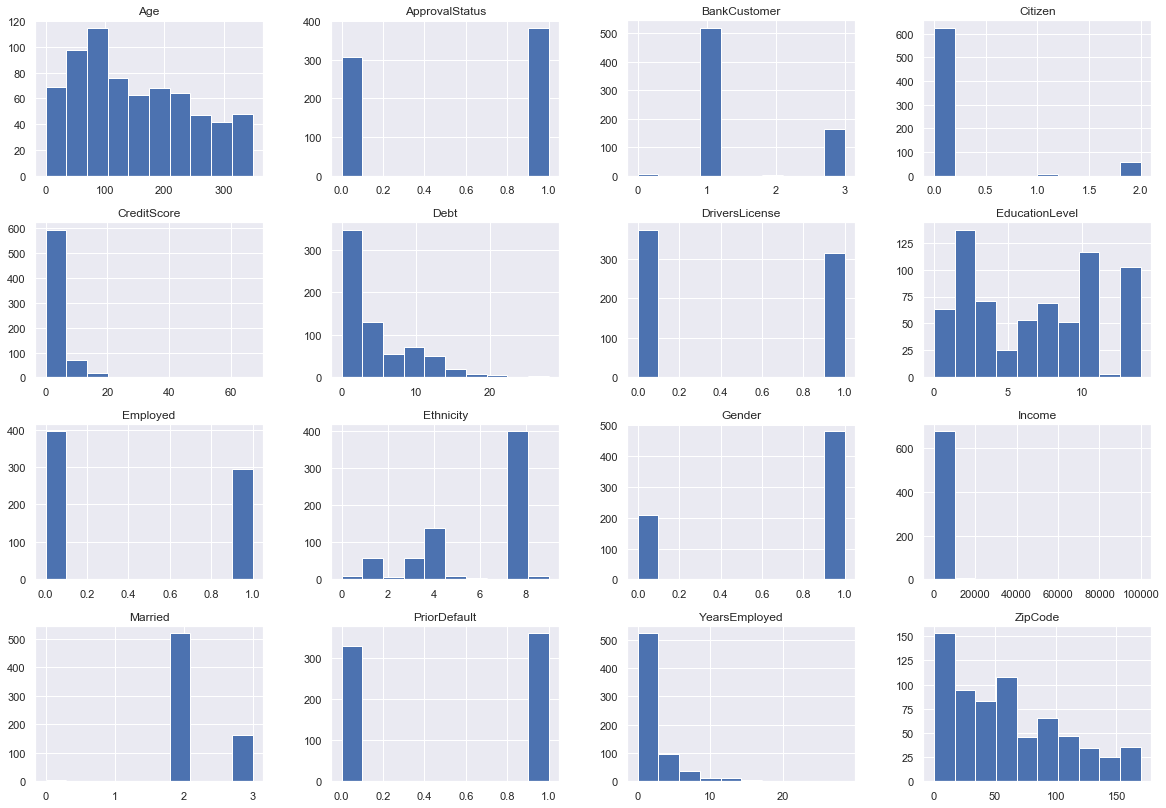

In [122]:
cc_apps.hist(figsize = [20,14])
plt.show()

<p>Now I will split the data into train set and test set to prepare our data for machine learning modeling; Firstly, I will split the data and then apply the scaling.</p>
<p>Also, features like <code>DriversLicense</code> and <code>ZipCode</code> are not as important as the other features in the dataset for predicting credit card approvals. </p>

In [123]:
cc_apps = cc_apps.drop(['DriversLicense', 'ZipCode'], axis=1)
print(cc_apps.head())

   Gender  Age   Debt  Married  BankCustomer  EducationLevel  Ethnicity  \
0       1  156  0.000        2             1              13          8   
1       0  328  4.460        2             1              11          4   
2       0   89  0.500        2             1              11          4   
3       1  125  1.540        2             1              13          8   
4       1   43  5.625        2             1              13          8   

   YearsEmployed  PriorDefault  Employed  CreditScore  Citizen  Income  \
0           1.25             1         1            1        0       0   
1           3.04             1         1            6        0     560   
2           1.50             1         0            0        0     824   
3           3.75             1         1            5        0       3   
4           1.71             1         0            0        2       0   

   ApprovalStatus  
0               0  
1               0  
2               0  
3               0  
4   

In [124]:
cc_apps_arrays = cc_apps.values
X,y = cc_apps_arrays[:,0:13] , cc_apps_arrays[:,13]
X_train, X_test, y_train, y_test = train_test_split( X,y,test_size=0.33,random_state=42)



scaler = MinMaxScaler(feature_range=( 0, 1))
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.fit_transform(X_test)

<p>predicting if a credit card application will be approved or not is a classification task. According to UCI, our dataset contains more instances that correspond to "Denied" status than instances corresponding to "Approved" status. Specifically, out of 690 instances, there are 383 (55.5%) applications that got denied and 307 (44.5%) applications that got approved.</p>

In [125]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)


y_pred = logreg.predict(rescaledX_test)
print("Accuracy of logistic regression classifier: ", logreg.score(rescaledX_test , y_test) )
print(confusion_matrix(y_test, y_pred))

Accuracy of logistic regression classifier:  0.8421052631578947
[[95  8]
 [28 97]]


<p>I will perform a <a href="https://machinelearningmastery.com/how-to-tune-algorithm-parameters-with-scikit-learn/">grid search</a> of the model parameters to improve the model's ability to predict credit card approvals.</p>
<p><a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html">scikit-learn's implementation of logistic regression</a> consists of different hyperparameters but we will grid search over the following:</p>
<ul>
<li>tol</li>
<li>max_iter</li>
</ul>



In [126]:
tol = [.01,.001,.0001]
max_iter = [100,150,200,500,1000]
C = [1.0, .1, .4 , .7]
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
param_grid = dict( tol=tol, max_iter=max_iter, C=C, solver=solver)

<p>I add the deferant hyperparameter into a single dictionary which <code>GridSearchCV()</code> expects a dict one of its parameters.</p>
<p>Instantiatetion of <code>GridSearchCV()</code> will be with <code>logreg</code> model with all the data we have. Also, will instruct <code>GridSearchCV()</code> to perform a <a href="https://www.dataschool.io/machine-learning-with-scikit-learn/">cross-validation</a> of five folds.</p>

In [127]:
grid_model = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5)
rescaledX = scaler.fit_transform(X)
grid_model_result = grid_model.fit(rescaledX , y)


best_score, best_params = grid_model_result.best_score_, grid_model_result.best_params_
print("Best: {0:.3f} using {1}".format(best_score, best_params))

Best: 0.854 using {'C': 1.0, 'max_iter': 100, 'solver': 'liblinear', 'tol': 0.01}
